# Data and Analysis Plan: MLB Build a Team

## Team 4
- Tim Seymour (seymour.ti@northeastern.edu)

## Project Goal:
The goal of this project is to be able to predict how many wins any combination of players would have over a 162 game season. To do this, I build a classification model to estimate whether a team will win a given game. To generate a new data point, I will aggregate the statistics for a given lineup, rotation, and bullpen. For this new data point, I will use predict_proba to determine how likely that team is to win a given game - multiplying this value by 162 will give an estimate of how many wins that team would have assuming full health.
- My original idea was to build a regression model with team win totals over a season as the target, but this severely limits the size of the data set. My preference was to use data from as recently as possible because baseball has changed dramatically throughout its history, so including data from past eras could water down the significance of home run rate and strikeout rate in predicting the winner of a single game.

<a id='data'></a>

## Data
I will obtain statistics from FanGraphs including:

'HR', 'R', 'RBI', 'SB', 'BB%',
       'K%', 'ISO', 'BABIP_x', 'AVG', 'OBP', 'SLG', 'wOBA', 'xwOBA', 'wRC+',
       'BsR', 'Off', 'Def', 'WAR_x' (Hitter's war), 'SV',
       'K/9', 'BB/9', 'HR/9', 'BABIP_y', 'LOB%', 'GB%', 'HR/FB', 'vFA (pi)',
       'ERA', 'xERA', 'FIP', 'xFIP', 'WAR_y' (Pitcher's war)

There are considerations to be made about the inclusion of several of these statistics with many relying on luck which should not be projected over a season sample size. This will have a large effect on my feature selection process - stats used should be under team and player control. For example, BABIP or Batting Average on Balls in Play is a metric that will vary game to game and likely has more to do with luck than skill. While exit velocity and defensive alignment will have an impact, it is more practical to use a different statistic for generalization purposes. 

A stat like Saves also implies a win, so this would lead to overfitting. I will analyze the choices that I make in the feature selection process as I go. One other consideration is that it would be preferable to include at least one statistic representing each facet of the game - Def and BsR are the only defensive and baserunning advanced statistics that are kept on a game to game basis, so provided they have even a 2-3 game impact over a season they will be included in the model.

As for the inclusion of pitching and hitting statistics, I will make it a priority to include statistics that do not correlate strongly with each other (avoiding autocorrelation) to ensure the model has diverse features.

In [1]:
import datetime
import pandas as pd
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics as m
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import plotly
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from jupyter_dash import JupyterDash
import seaborn as sns
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash import dash_table
from dash.dependencies import Input, Output, State
import json
from dash.exceptions import PreventUpdate
from sklearn.naive_bayes import GaussianNB

In [2]:
pd.set_option('display.max_columns', None)

# Data Collection

Scraping team data from 2015 and later

In [3]:
def date_to_str(date):
    '''
    Args:
        date (datetime): datetime object for the day of the season

    Returns:
        str: string representation of the given date

    '''
    month = str(date.month)
    day = str(date.day)
    if date.day <= 9:
        day = str(0) + day
    if date.month <= 9:
        month = str(0) + month
    return str(date.year) + '-' + month + '-' + day

To include advanced stats on a game by game basis, I found FanGraphs to have the best combinations of metrics that would be helpful in predicting the winner of a single game.

Scraping process takes ~20 minutes

In [4]:
def collect_team_data():
    '''
    Scrapes FanGraphs data from each day between April 1, 2015 and today's date

    Returns:
        hit (pd.DataFrame) contains hitting stats with each record representing one game for a team
        pit (pd.DataFrame) contains pitching stats with each record representing one game for a team
    '''
    # beginning of sample is 2015
    first_date = datetime.datetime(year = 2015, month = 4, day = 1)
    # When date reaches last date, date resets to first_date (plus one year)
    last_date = datetime.datetime(year = 2015, month = 10, day = 3)
    date = datetime.datetime(year = 2015, month = 4, day = 1)
    # collects team hitting stats for each day
    hit = pd.DataFrame()
    # collects team pitching stats for each day
    pit = pd.DataFrame()
    # sustainable way of changing year without change in code
    while (date < datetime.datetime.now()):
        date_str = date_to_str(date)
        print(date_str)
        # scrape hitting data
        hit_df = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season={date.year}&month=1000&season1={date.year}&ind=0&team=0%2Cts&rost=0&age=0&filter=&players=0&startdate={date_str}&enddate={date_str}')
        # getting rid of the final row with non-numeric data
        hit_df = hit_df[16][:-1]
        hit_df[('temp', 'Date')] = date_str
        hit_df.columns = hit_df.columns.droplevel(0)
        if len(hit_df['#']) > 1:
            hit = hit.append(hit_df)
        # scrape pitching data
        pit_df = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season={date.year}&month=1000&season1={date.year}&ind=0&team=0%2Cts&rost=0&age=0&filter=&players=0&startdate={date_str}&enddate={date_str}')
        # getting rid of the final row with non-numeric data
        pit_df = pit_df[16][:-1]
        pit_df[('temp', 'Date')] = date_str
        pit_df.columns = pit_df.columns.droplevel(0)
        if len(pit_df['#']) > 1:
            pit = pit.append(pit_df)
        if (date < last_date):
            date += datetime.timedelta(days = 1)
        else:
            print(date.year)
            last_date = datetime.datetime(year = last_date.year + 1, month = last_date.month, day = last_date.day)
            first_date = datetime.datetime(year = first_date.year + 1, month = first_date.month, day = first_date.day)
            date = first_date
    return hit, pit

In [5]:
# hit, pit = collect_team_data()

# Shortened Data Collection

In [74]:
all_stats = pd.read_csv("C:/Users/timse/OneDrive/Documents/MLB Project/MLB-Build-a-Team/static_data/daily_stats.csv", encoding="utf-8")

In [75]:
all_stats.head()

,Unnamed: 0,#_x,Team,G,PA,HR,R,RBI,SB,BB%,K%,ISO,BABIP_x,AVG,OBP,SLG,wOBA,xwOBA,wRC+,BsR,Off,Def,WAR_x,Date,#_y,W,L,SV,GS,IP,K/9,BB/9,HR/9,BABIP_y,LOB%,GB%,HR/FB,vFA (pi),ERA,xERA,FIP,xFIP,WAR_y
0,0,1,STL,14,40,0,3,3,4,10.0%,27.5%,0.083,0.400,0.278,0.350,0.361,0.308,NaN,97,0.4,0.1,0.5,0.2,2015-04-05,1,1,0,1,1,9.0,12.0,2.0,0.0,0.250,100.0%,50.0%,0.0%,92.6,0.0,NaN,1.13,1.79,0.4
1,1,2,CHC,16,34,0,0,0,1,5.9%,35.3%,0.094,0.250,0.156,0.206,0.250,0.203,NaN,27,0.3,-2.9,0.0,-0.2,2015-04-05,2,0,1,0,1,9.0,11.0,4.0,0.0,0.400,78.6%,40.0%,0.0%,93.2,3.0,NaN,2.02,3.33,0.2
2,2,1,KCR,13,42,2,10,9,2,11.9%,7.1%,0.265,0.379,0.382,0.488,0.647,0.478,NaN,222,0.3,6.1,0.1,0.8,2015-04-06,20,1,0,0,1,9.0,3.0,2.0,1.0,0.167,100.0%,56.0%,14.3%,95.3,1.0,NaN,4.91,4.62,0.0
3,3,2,BOS,13,42,5,8,8,1,16.7%,21.4%,0.429,0.190,0.257,0.381,0.686,0.444,NaN,191,0.1,4.2,0.1,0.6,2015-04-06,4,1,0,0,1,9.0,9.0,2.0,0.0,0.136,100.0%,52.4%,0.0%,93.6,0.0,NaN,1.80,2.62,0.4
4,4,3,COL,15,44,2,10,10,0,2.3%,13.6%,0.286,0.412,0.381,0.395,0.667,0.451,NaN,185,0.0,4.1,0.2,0.6,2015-04-06,5,1,0,0,1,9.0,9.0,0.0,0.0,0.333,100.0%,33.3%,0.0%,90.6,0.0,NaN,1.47,2.62,0.3


# Cleaning

The data cleaning process consisted of changing the data type of each numerical column from a string to a float. I also dropped columns that did not have values for most game logs ('xwOBA', 'xERA'), columns that do not have anything to do with whether a game is won ('Team', 'G', 'Date', 'GS'), and columns that were disqualified as valid predictors ('PA', 'R', 'L', 'SV', 'IP', 'RBI')

In [77]:
# These columns have only null values for single games
all_stats.drop(columns = ['xwOBA', 'xERA'], inplace = True)

In [78]:
# turning every value in the dataframe into a float
def string_to_num(string):
    if(string == 'NA'):
        return 'NA'
    elif(type(string) == str):
        if('%' in string):
            string = string.replace('%', '')
    return float(string)

In [79]:
# applying the function to each column to ensure all data points are numerical
for col in all_stats.columns:
    if col not in ['Team', 'Date', 'GB']:
        all_stats[col] = all_stats[col].apply(string_to_num)

### Subjective decision made to exclude RBI
RBI is a statistic that is often outside of player control as it is highly dependent on how often runners are in scoring position for their at bats. It also could lead to overfitting as almost all runs result in an RBI and comparing RBIs to ERA would make for too obvious of a prediction. I have not excluded ERA to this point because, while it is a bit more within a player's control and is therefore more representative of their performance.

In [80]:
all_stats = all_stats.drop(columns = ['#_x', 'Team', 'G', 'PA', 'R',
       'Date', '#_y', 'L', 'SV', 'GS', 'IP', 'RBI', 'Unnamed: 0'])
# Only ~100 columns with null values
all_stats.dropna(inplace = True)

# Data Pre-Processing

The first step of preprocessing was to separate the data into X and y with 'W' (win) being the target variable. The next step is to scale X using StandardScaler to normalize the dataset. I then store the factors used in scaling each feature in a dictionary to be used in scaling aggregated player data for prediction. Finally, I split the data randomly into train, test, and validation sets with 15% used for validation.

In [81]:
X = all_stats.drop(columns = ['W'])
cols = X.columns
y = all_stats['W']

In [82]:
#Scaling each column to be 
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns = cols)

In [83]:
#Storing values used to scale each feature for manual normalization in later step
feat_names = np.append(scaler.get_feature_names_out()[:-1], 'WAR')
scales = pd.DataFrame({'Feature': feat_names, 'Unit Variance': scaler.scale_, 'Mean': scaler.mean_})
scales.set_index('Feature', inplace = True)

In [84]:
X

,HR,SB,BB%,K%,ISO,BABIP_x,AVG,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR_x,K/9,BB/9,HR/9,BABIP_y,LOB%,GB%,HR/FB,vFA (pi),ERA,FIP,xFIP,WAR_y
0,-1.026693,4.213351,0.389798,0.632761,-0.733865,1.160386,0.413582,0.452521,-0.282579,-0.018308,0.013771,1.565807,0.088338,1.571914,0.271676,1.240666,-0.595483,-1.010722,-0.399011,1.421366,0.544532,-1.052587,-0.455563,-1.332203,-1.488352,-1.860683,1.337282
1,-1.026693,0.602534,-0.473674,1.579235,-0.631284,-0.417499,-1.118942,-1.278163,-0.967433,-1.183020,-1.176013,1.174978,-0.957510,-0.177217,-1.040534,0.892468,0.368980,-1.010722,1.196332,0.195205,-0.355636,-1.052587,-0.124491,-0.406834,-1.066900,-0.695837,0.396994
2,0.688349,1.806140,0.789944,-1.842635,0.963400,0.939482,1.719996,2.111094,1.482000,1.867418,2.138385,1.174978,2.180033,0.172609,2.239990,-1.893113,-0.595483,-0.189020,-1.281767,1.421366,1.084633,0.103016,1.034259,-1.023747,0.301634,0.279911,-0.543293
3,3.260912,0.602534,1.800838,-0.107431,2.492804,-1.048653,0.149787,0.825099,1.722625,1.490272,1.611481,0.393320,1.517663,0.172609,1.583886,0.196073,-0.595483,-1.010722,-1.611471,1.421366,0.760573,-1.052587,0.096223,-1.332203,-1.171079,-1.232877,1.337282
4,0.688349,-0.601071,-1.231844,-1.053906,1.159238,1.286617,1.707434,0.993360,1.605398,1.567920,1.509499,0.002491,1.482801,0.522435,1.583886,0.196073,-1.559945,-1.010722,0.483746,1.421366,-0.958749,-1.052587,-1.559134,-1.332203,-1.327348,-1.232877,0.867138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30434,-1.026693,-0.601071,0.979487,1.336550,-0.342189,0.276770,-0.716968,0.248204,-0.578732,-0.051585,-0.071213,-2.342484,-0.295140,-0.876870,-0.384429,-0.152125,1.815673,-0.189020,0.217855,0.097799,-0.292624,-0.317203,2.137830,0.210078,0.547875,1.013613,-0.543293
30435,-1.026693,-0.601071,2.264165,-0.738414,-0.883076,-1.290596,-1.407860,-0.184467,-1.275926,-0.661673,-0.581121,0.393320,-0.504309,-1.926349,-0.712481,0.544271,-0.113251,-0.189020,1.908919,-1.890415,-1.921929,-0.317203,0.041044,2.060816,-0.451297,-0.582378,-0.073150
30436,-1.026693,-0.601071,-1.126543,-0.010357,-1.237450,-0.322826,-0.566228,-1.085865,-1.097000,-1.160835,-1.040038,-0.388338,-0.887787,-0.876870,-1.040534,0.196073,0.069996,0.838108,0.483746,-0.377768,0.886596,0.967698,1.144616,0.404406,0.571552,-0.536994,-1.013437
30437,-1.026693,-0.601071,-0.263071,-0.617071,-1.507893,-1.616692,-1.684217,-1.686797,-1.825043,-1.870755,-1.719914,-0.388338,-1.201541,0.522435,-1.368586,-0.500323,2.780136,-1.010722,-0.399011,-0.263173,-1.066769,-1.052587,-0.400384,-0.098378,0.287428,1.906158,-1.013437


In [85]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, random_state=100)
#Saving testing set for final model testing
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.25, random_state=100)

# Feature Selection

My approach to feature selection is to use recursive feature elimination with a logistic regression model to determine the optimal number of features. Once the results of each model is recorded, I plot the train and test accuracy against the number of features to evaluate for overfitting.

In [86]:
# selects the X most important features to be used for the model
def feature_selection(x_train, x_test, y_train, num_feats, print_bool):
    '''
    Args:
          x_train (pd.DataFrame): training set
          x_test (pd.DataFrame): testing set
          y_train (pd.DataFrame): target variable
          num_feats (int): number of features to select
          print_bool (boolean): decides whether or not to print selected features

    Returns:
          X_train_selected (np.array) contains new training set with optimal features selected
          X_test_selected (np.array) contains new testing set with optimal features selected

  '''
    # instantiate
    select = RFE(DecisionTreeRegressor(random_state = 300), n_features_to_select = num_feats)
    
    # fit the RFE selector to the training data
    select.fit(x_train, y_train)
    
    # transform training and testing sets so only the selected features are retained
    X_train_selected = select.transform(x_train)
    X_test_selected = select.transform(x_test)
    
    if print_bool:
      # prints selected features/Sample Output
      selected_features = [feature for feature, status in zip(x_train, select.get_support()) if status == True]
      
      print('Selected features:')
      for feature in selected_features:
            print(feature)

    # returns selected features
    return X_train_selected, X_test_selected

In [87]:
def calc_metrics(y_pred, y_actual, test_or_train, print_bool):
    '''
    input empty string for test_or_train if not relevant
    otherwise put train or test with trailing space

    Args:
        y_pred (pd.DataFrame): values predicted by classifier
        y_actual (pd.DataFrame): actual values
        test_or_train (str): string that will precede metrics to distinguish training, testing measurements
        print_bool (boolean): decides whether or not to print selected features

    Returns:
        results (Dict) contains metrics in format to be added to DataFrame
    '''
    a = accuracy_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred)
    prec = precision_score(y_actual, y_pred)
    rec = recall_score(y_actual, y_pred)
    auc = m.roc_auc_score(y_actual, y_pred)
    results = {f'{test_or_train}Accuracy': a, f'{test_or_train}Error': 1-a, f'{test_or_train}Precision': prec, f'{test_or_train}Recall': rec,
          f'{test_or_train}F1 Score': f1, f'{test_or_train}AUC': auc}
    if(print_bool):
        print(f'{test_or_train}Error: {1 - a}')
        print(f'{test_or_train}Accuracy: {a}')
        print(f'{test_or_train}Precision: {prec}')
        print(f'{test_or_train}Recall: {rec}')
        print(f'{test_or_train}F1: {f1}')
        print(f'{test_or_train}AUC: {auc}')
    return results


Evaluating Logistic Regression Performance with different amounts of features

In [88]:
#list of dictionaries to make a DataFrame
dicts = []
# Evaluating models with 1 - 15 features
for num_feat in range(1, 16, 1):
    train, test = feature_selection(X_train, X_test, y_train, num_feat, False)
    LR = LogisticRegression()
    LR = LR.fit(train, y_train)
    # Training predictions
    y_pred_tr = LR.predict(train)
    # Testing predictions
    y_pred_test = LR.predict(test)
    train_results = calc_metrics(y_pred_tr, y_train, 'Train ', False)
    test_results = calc_metrics(y_pred_test, y_test, 'Test ', False)
    train_results.update(test_results)
    train_results['Num Features'] = num_feat
    dicts.append(train_results)
df = pd.DataFrame(dicts)
#Repeating the process excluding result-oriented statistics (LOB%, BABIP)
#list of dictionaries to make a DataFrame
dicts = []
# Evaluating models with 1 - 15 features
for num_feat in range(1, 16, 1):
    train, test = feature_selection(X_train.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y']), X_test.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y']), y_train, num_feat, False)
    LR = LogisticRegression()
    LR = LR.fit(train, y_train)
    # Training predictions
    y_pred_tr = LR.predict(train)
    # Testing predictions
    y_pred_test = LR.predict(test)
    train_results = calc_metrics(y_pred_tr, y_train, 'Train ', False)
    test_results = calc_metrics(y_pred_test, y_test, 'Test ', False)
    train_results.update(test_results)
    train_results['Num Features'] = num_feat
    dicts.append(train_results)
df_excluding = pd.DataFrame(dicts)
# Renaming Columns for graphing purposes
for col in df_excluding.columns:
    df_excluding.rename(columns = {col: col + ' excluding LOB%, BABIP'}, inplace = True)
df = pd.concat([df, df_excluding], axis = 1)

In [73]:
df

,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1 Score,Train AUC,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1 Score,Test AUC,Num Features,"Train Accuracy excluding LOB%, BABIP","Train Error excluding LOB%, BABIP","Train Precision excluding LOB%, BABIP","Train Recall excluding LOB%, BABIP","Train F1 Score excluding LOB%, BABIP","Train AUC excluding LOB%, BABIP","Test Accuracy excluding LOB%, BABIP","Test Error excluding LOB%, BABIP","Test Precision excluding LOB%, BABIP","Test Recall excluding LOB%, BABIP","Test F1 Score excluding LOB%, BABIP","Test AUC excluding LOB%, BABIP","Num Features excluding LOB%, BABIP"
0,0.769120,0.230880,0.736476,0.844385,0.786748,0.768455,0.776936,0.223064,0.740549,0.847758,0.790536,0.777425,1,0.769120,0.230880,0.736476,0.844385,0.786748,0.768455,0.776936,0.223064,0.740549,0.847758,0.790536,0.777425,1
1,0.901154,0.098846,0.898753,0.906100,0.902412,0.901111,0.902149,0.097851,0.896647,0.907534,0.902058,0.902186,2,0.901154,0.098846,0.898753,0.906100,0.902412,0.901111,0.902149,0.097851,0.896647,0.907534,0.902058,0.902186,2
2,0.903010,0.096990,0.900497,0.908041,0.904253,0.902965,0.904313,0.095687,0.898555,0.910025,0.904254,0.904352,3,0.903010,0.096990,0.900497,0.908041,0.904253,0.902965,0.904313,0.095687,0.898555,0.910025,0.904254,0.904352,3
3,0.905844,0.094156,0.903897,0.910085,0.906980,0.905807,0.905086,0.094914,0.901670,0.907846,0.904747,0.905105,4,0.903886,0.096114,0.901561,0.908654,0.905094,0.903844,0.904004,0.095996,0.898248,0.909714,0.903944,0.904043,4
4,0.906978,0.093022,0.906167,0.909778,0.907969,0.906953,0.908177,0.091823,0.903763,0.912204,0.907964,0.908205,5,0.903989,0.096011,0.902070,0.908246,0.905147,0.903951,0.905086,0.094914,0.899446,0.910648,0.905012,0.905124,5
5,0.911255,0.088745,0.911354,0.912844,0.912098,0.911241,0.910032,0.089968,0.908385,0.910648,0.909515,0.910037,6,0.903886,0.096114,0.901806,0.908348,0.905065,0.903846,0.905395,0.094605,0.900493,0.910025,0.905234,0.905427,6
6,0.910946,0.089054,0.911299,0.912231,0.911765,0.910935,0.910342,0.089658,0.908189,0.911582,0.909882,0.910350,7,0.903525,0.096475,0.901410,0.908041,0.904713,0.903485,0.906477,0.093523,0.901447,0.911270,0.906332,0.906510,7
7,0.912183,0.087817,0.912020,0.914070,0.913043,0.912166,0.910651,0.089349,0.910025,0.910025,0.910025,0.910646,8,0.904040,0.095960,0.902243,0.908143,0.905184,0.904004,0.906322,0.093678,0.902160,0.910025,0.906076,0.906348,8
8,0.915687,0.084313,0.916931,0.915807,0.916368,0.915686,0.916680,0.083320,0.915449,0.916874,0.916161,0.916681,9,0.904453,0.095547,0.902568,0.908654,0.905601,0.904416,0.906941,0.093059,0.903276,0.910025,0.906638,0.906962,9
9,0.915327,0.084673,0.916616,0.915398,0.916006,0.915326,0.916680,0.083320,0.915449,0.916874,0.916161,0.916681,10,0.906308,0.093692,0.904395,0.910494,0.907434,0.906271,0.909105,0.090895,0.906444,0.910959,0.908696,0.909118,10


In [89]:
px.line(df, x = 'Num Features', y = ['Train Accuracy', 'Test Accuracy', 'Train Accuracy excluding LOB%, BABIP', 'Test Accuracy excluding LOB%, BABIP'], title="Logistic Regression Accuracy with Different Numbers of Features",
            labels={ # replaces default labels by column name,
                'value': "Accuracy", 'variable': 'Accuracy Type'}, range_y = [.88, .93])

There is not much accuracy to be gained from using more than six or seven statistics 

### Feature selection favors result-oriented statistics, unsurprisingly
- LOB% signifies the percentage of baserunners that did not come around to score; this is a testament to the value of clutch hitting, although for this model this should not be factored in - timely hitting is more likely to be a result of luck
- BABIP_y is the percentage of balls put in play that result in hits which has an element of luck and is not as representative of the strength of a team or player as batting average itself

I have decided against using these metrics for the reasons I outline above and because as is seen in the graph, there is minimal gain in accuracy from their use.

In [75]:
feature_selection(X_train.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y']), X_test.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y']), y_train, 10, True);

Selected features:
K%
OBP
SLG
wOBA
Off
GB%
vFA (pi)
ERA
FIP
xFIP


In [19]:
X_train = X_train.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y'])
X_test = X_test.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y'])

The next means of feature selection used was to use to train random forest and adaboost classifiers to access the feature importance attribute. ERA was the most important feature as was expected because most runs are earned runs, so it is nearly one to one with runs given up.

In [77]:
RFC = RandomForestClassifier() 
RFC.fit(X_train, y_train)

feature_importances = RFC.feature_importances_
feature_importances

array([0.00788906, 0.00494733, 0.01471466, 0.0161789 , 0.02621049,
       0.03061681, 0.0365534 , 0.03619616, 0.07035569, 0.05744592,
       0.01124688, 0.08435019, 0.01177243, 0.05719194, 0.01320853,
       0.02587564, 0.06539333, 0.01572175, 0.01591331, 0.01518327,
       0.25847443, 0.04340966, 0.02447909, 0.05667115])

In [78]:
ADA = AdaBoostClassifier() 
ADA.fit(X_train, y_train)

feature_importances_ada = ADA.feature_importances_
feature_importances_ada

array([0.  , 0.  , 0.  , 0.04, 0.04, 0.04, 0.04, 0.  , 0.14, 0.  , 0.02,
       0.1 , 0.02, 0.  , 0.  , 0.  , 0.18, 0.  , 0.02, 0.  , 0.24, 0.02,
       0.  , 0.1 ])

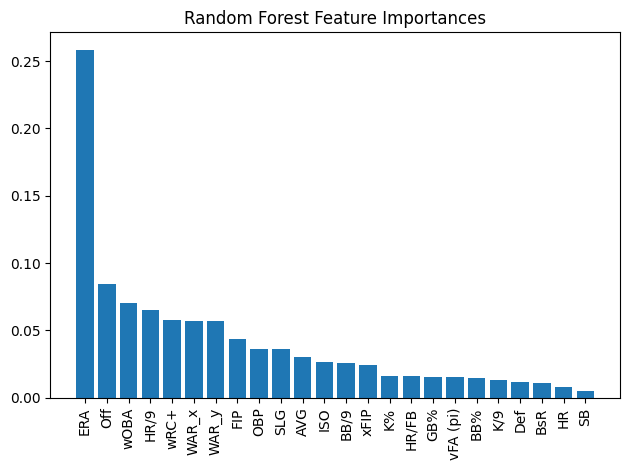

In [79]:
sorted = np.argsort(feature_importances)[::-1]

plt.title('Random Forest Feature Importances')
plt.bar(range(X_train.shape[1]), feature_importances[sorted], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted], rotation=90)
plt.tight_layout()
plt.show()

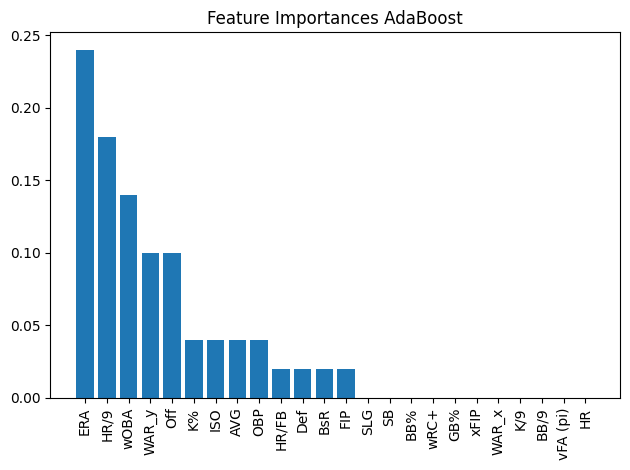

In [80]:
sorted = np.argsort(feature_importances_ada)[::-1]

plt.title('Feature Importances AdaBoost')
plt.bar(range(X_train.shape[1]), feature_importances_ada[sorted], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted], rotation=90)
plt.tight_layout()
plt.show()

Here, I visualize each feature's correlation with every other feature, and then isolate each feauture's correlation with win percentage. Stats like WAR, FIP, and HR/9 stood out as statistics that could be best predictive of winning.

In [91]:
corr_to_win = all_stats.corr()[['W']].sort_values('W', ascending = False)

<AxesSubplot: >

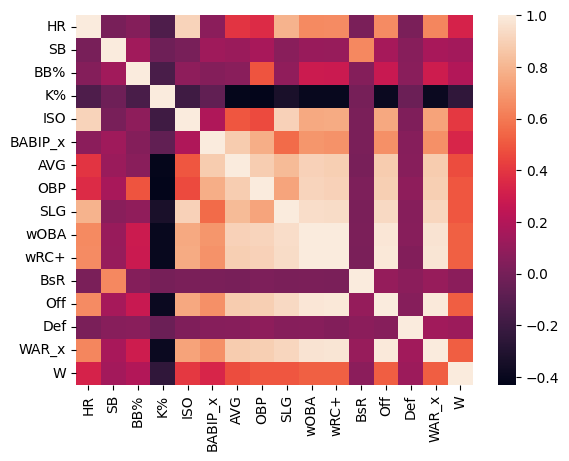

In [82]:
# Interesting to note how offensive statistics have higher correlations with one another than pitching statistics
sns.heatmap(all_stats[['HR', 'SB', 'BB%', 'K%', 'ISO', 'BABIP_x', 'AVG', 'OBP', 'SLG', 'wOBA',
       'wRC+', 'BsR', 'Off', 'Def', 'WAR_x', 'W']].corr())

<AxesSubplot: >

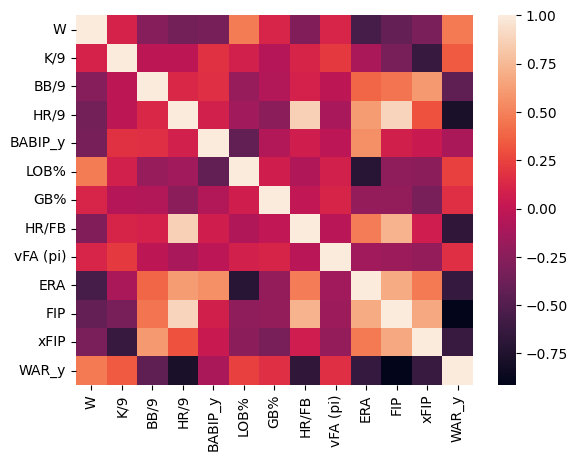

In [83]:
# Interesting to note how offensive statistics have higher correlations with one another than pitching statistics
sns.heatmap(all_stats[['W', 'K/9', 'BB/9', 'HR/9',
       'BABIP_y', 'LOB%', 'GB%', 'HR/FB', 'vFA (pi)', 'ERA', 'FIP', 'xFIP',
       'WAR_y']].corr())

In [92]:
corr_to_win.rename(columns={'W':'Corr'}).T

,W,wOBA,wRC+,WAR_x,Off,SLG,OBP,LOB%,AVG,WAR_y,ISO,BABIP_x,HR,BB%,SB,Def,vFA (pi),GB%,K/9,BsR,K%,BB/9,HR/FB,xFIP,BABIP_y,HR/9,FIP,ERA
Corr,1.0,0.525073,0.523888,0.519281,0.518843,0.497097,0.493269,0.472807,0.467611,0.463539,0.40408,0.336489,0.325293,0.197821,0.148103,0.126587,0.117364,0.113905,0.101714,0.067254,-0.250971,-0.269649,-0.287725,-0.316824,-0.330955,-0.349628,-0.41926,-0.557613


In [100]:
fig = px.bar(corr_to_win, title='Correlation to Winning')
# make y-axis invisible in plot
fig.update_yaxes(title = 'Correlation to W-L%', visible = True, showticklabels = True)
fig.update_xaxes(title = 'Statistic', visible = True, showticklabels = True)

fig

ERA is dominant in terms of AdaBoost and Random Forest feature importance, although it is not regarded as the best measurement of inidividual pitching performance because it is known to be dependent on the quality of the pitcher's defense. For the purposes of my investigation, I would like to be able to assume a pitcher's defense will be whatever the inputted lineup will offer them, so despite this stat's effectiveness in win prediction, my next step is to look into the tradeoff of using FIP or pitching WAR in its place.

## Deciding which pitching statistics to use with Logistic Regression as a baseline model
FIP, ERA, and WAR_y have many common factors in their calculations, so I have decided to choose only one of the three so as to have diverse features that will not contradict each other in prediction
- Note: Pitching WAR is calculated using the following formula: 
  
  WAR = [[([(League “FIP” – “FIP”) / Pitcher Specific Runs Per Win] + Replacement Level) * (IP/9)] * Leverage Multiplier for Relievers] + League Correction

In [93]:
X_train = X_train[['wRC+', 'HR/9', 'BsR', 'FIP', 'WAR_y', 'ERA', 'Def', 'SLG']]
X_test = X_test[['wRC+', 'HR/9', 'BsR', 'FIP', 'WAR_y', 'ERA', 'Def', 'SLG']]

In [94]:
dicts = []
pitch_stats = [{'ERA': ['FIP', 'WAR_y']}, {'WAR_y': ['FIP', 'ERA']}, {'FIP': ['ERA', 'WAR_y']}]
for drop_stats in pitch_stats:
    drop = list(drop_stats.values())
    drop = drop[0]
    stat = list(drop_stats.keys())
    stat = stat[0]
    xt = X_train.drop(columns = drop)
    xte = X_test.drop(columns = drop)
    LR = LogisticRegression()
    LR = LR.fit(xt, y_train)
    # Training predictions
    y_pred_tr = LR.predict(xt)
    # Testing predictions
    y_pred_test = LR.predict(xte)
    train_results = calc_metrics(y_pred_tr, y_train, 'Train ', False)
    test_results = calc_metrics(y_pred_test, y_test, 'Test ', False)
    train_results.update(test_results)
    train_results['Feature Used'] = stat
    dicts.append(train_results)
df = pd.DataFrame(dicts)

In [95]:
df

,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1 Score,Train AUC,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1 Score,Test AUC,Feature Used
0,0.901361,0.098639,0.900336,0.904567,0.902446,0.901332,0.902149,0.097851,0.896891,0.907223,0.902028,0.902184,ERA
1,0.833539,0.166461,0.832606,0.838561,0.835573,0.833495,0.833668,0.166332,0.825610,0.843088,0.834258,0.833733,WAR_y
2,0.814832,0.185168,0.814034,0.820272,0.817141,0.814784,0.812954,0.187046,0.805742,0.821295,0.813444,0.813012,FIP


In [97]:
px.bar(df, x = 'Feature Used', y = df.drop(columns = ['Feature Used', 'Test Error', 'Train Error']).columns, title="Logistic Regression Performance with Different Pitching Stats",
            labels={ # replaces default labels by column name,
                'value': "Score", 'variable': 'Accuracy Type'}, barmode = 'group', range_y = [.77, .92])

Despite the ERA model's better performance across the board, I will use the WAR model because it is a better representation of a single pitcher's performance rather than the defense and pitching combined of a team. FIP is part of the calculation of WAR, so the WAR model is the obvious choice considering it is a better indicator of team success (which is expected as it is normalized for competition)

# Finalizing Training and Testing Sets

In [106]:
X_train = X_train[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
X_test = X_test[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
X_tr = X_tr[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
X_te = X_te[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
X = X[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]

<a id='visualization_2'></a>

# VISUALIZATION

In [22]:
def clean_team_data(team_data):
    # applying the function to each column to ensure all data points are numerical
    for col in team_data.columns:
        if col not in ['Team', 'Season', 'GB']:
            team_data[col] = team_data[col].apply(string_to_num)
    # Saving a copy of the scraped data 
    return team_data

In [23]:
import MySQLdb
db = MySQLdb.connect(host='127.0.0.1', user='root', passwd='', db='mlb_db')
tblchk = db.cursor()
sql_team_data = pd.read_sql('SELECT * FROM team_data', con = db)
team_data = clean_team_data(sql_team_data)

<ipython-input-23-b76db3f4eb91>:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_team_data = pd.read_sql('SELECT * FROM team_data', con = db)


In [64]:
import plotly.express as px
import statsmodels

px.scatter(team_data, x='BsR', y='W', hover_data = ['Team'], trendline='ols', title='BsR vs Winning')

In [89]:
px.scatter(team_data, 'wRC_plus', 'W', hover_data = ['Team'], trendline='ols', title='wRC+ vs Winning')

In [90]:
px.scatter(team_data, 'FIP', 'W', hover_data = ['Team'], trendline='ols', title='FIP vs Winning')

In [91]:
px.scatter(team_data, 'WAR_y', 'W', hover_data = ['Team'], trendline='ols', title='WAR vs Winning')

In [92]:
px.scatter(team_data, 'Def', 'W', hover_data = ['Team'], trendline='ols', title='Def vs Winning')

# Tuning Models

To tune the models, I build a function that will graph model performance (train and test accuracy) for different hyperparameter values, and I will run GridSearch before deciding which values will perform the best.

## Graphing hyperparameter tuning function

In [101]:
import matplotlib.pyplot as plt

def graph_hyper(model, val_list, val_name, arguments):
    '''
    Args:
      model: Sklearn object with global variable representing hyperparameter value
      val_list: values for hyperparameter to choose between
      val_name: hyperparameter name for naming axes, titling

    Purpose:
      Graph the testing vs training accuracy for different values of hyperparameters
    '''

    values = {}
    metrics_output = []

    for threshold in val_list:
        arguments[val_name] = threshold
        clf = model(**arguments)
        clf = clf.fit(X_train, y_train)
        y_train_prediction = clf.predict(X_train)
        y_test_prediction = clf.predict(X_test)
        training_accuracy = accuracy_score(y_train, y_train_prediction)        
        testing_accuracy = accuracy_score(y_test, y_test_prediction)

        values = {val_name : threshold,
                  'Training Accuracy' : training_accuracy,
                  'Testing Accuracy' : testing_accuracy}
        metrics_output.append(values)

    return px.line(metrics_output, x= val_name, y = ['Training Accuracy', 'Testing Accuracy'], title=f'Accuracy for Various {val_name} Values', 
                 labels={'variable': 'Accuracy Type', 'value': 'Accuracy'})

## Tuning RandomForestClassifier

In [43]:
graph_hyper(RandomForestClassifier, [10, 20, 30, 40, 50], 'n_estimators', {'n_estimators': 0, 'criterion': 'entropy', 'random_state': 100})

From this plot, it is clear there is not much accuracy to be gained from having more than 30 estimators:

- Testing Accuracy goes from .849 to .851 when using 30 and 40 estimators

In [107]:
graph_hyper(RandomForestClassifier, range(1, 25, 1), 'max_depth', {'n_estimators': 30, 'max_depth': 0, 'criterion': 'entropy', 'random_state': 100})

From this plot, it is clear there is not much accuracy to be gained from having more than 6 as the max depth and the model clearly overfits after this threshold:

- Testing Accuracy goes from .851 to .861 when using 6 and 10 as the max depth and the gap between training and testing accuracy balloons from .0018 to .0252

### Using GridSearch to inform best hyperparameters based on graph output

In [45]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [20, 30, 40]
grid['max_depth'] = [6, 7, 8]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=rfc, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.853930 using {'max_depth': 8, 'n_estimators': 40}


To avoid overfitting, I will use a max depth of 6 and 30 for n_estimators

## Tuning AdaBoost hyperparameters

In [46]:
graph_hyper(AdaBoostClassifier, [10, 20, 30, 50, 60, 70, 80, 90, 100], 'n_estimators', {'n_estimators': 0})

Testing accuracy actually exceeds training accuracy until 60 estimators were used. 80 estimators had practically the same training as testing accuracy and .004 better testing accuracy than the model with 50 estimators

In [47]:
graph_hyper(AdaBoostClassifier, [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 1.0], 'learning_rate', {'n_estimators': 50, 'learning_rate': 0})

Testing accuracy actually exceeds training accuracy for the model with a learning rate of 1 and it has the highest accuracy of any model, so a learning rate of 1 is the obvious choice

### Using GridSearch to inform best hyperparameters based on graph output

In [48]:
ada = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [60, 70, 80, 100]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=ada, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.855270 using {'learning_rate': 1.0, 'n_estimators': 100}


I will use a learning rate of 1 and 80 for n_estimators

## MLP Hyperparameter tuning

In [49]:
from sklearn.model_selection import GridSearchCV
grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive']}

mlp = MLPClassifier()
# define the grid search procedure
grid_search = GridSearchCV(estimator=mlp, param_grid=grid, n_jobs=-1, cv=3, scoring='accuracy', verbose = 10)
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best: 0.840600 using {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [50]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

## Gradient Booster Hyperparameter tuning

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8604111918379966

## Comparing tuned model performances

With hyperparameter values set, this section collects metrics for each model using the final testing set to determine the best performing models.

In [24]:
def print_metrics(y_pred, y_actual, test_or_train, print_bool):
    '''
    input empty string for test_or_train if not relevant
    otherwise put train or test with trailing space
    '''
    a = accuracy_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred)
    prec = precision_score(y_actual, y_pred)
    rec = recall_score(y_actual, y_pred)
    auc = m.roc_auc_score(y_actual, y_pred)

    if(print_bool):
        print(f'{test_or_train}Error: {1 - a}')
        print(f'{test_or_train}Accuracy: {a}')
        print(f'{test_or_train}Precision: {prec}')
        print(f'{test_or_train}Recall: {rec}')
        print(f'{test_or_train}F1: {f1}')
        print(f'{test_or_train}AUC: {auc}')
    return {f'{test_or_train}Accuracy': a, f'{test_or_train}Error': 1-a, f'{test_or_train}Precision': prec, f'{test_or_train}Recall': rec,
          f'{test_or_train}F1 Score': f1, f'{test_or_train}AUC': auc}

In [38]:
for model in [GaussianNB(), LogisticRegression(), RandomForestClassifier(n_estimators = 30, max_depth = 6), AdaBoostClassifier(learning_rate = 1, n_estimators = 80),
              MLPClassifier(activation='relu', alpha=0.05, hidden_layer_sizes=(50,50,50), learning_rate='adaptive', solver='adam')]:
    print(model)
    model = model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    print_metrics(y_pred, y_te, '', True)

GaussianNB()
Error: 0.1809023215067893
Accuracy: 0.8190976784932107
Precision: 0.8127812781278128
Recall: 0.8149819494584838
F1: 0.8138801261829653
AUC: 0.8189803364313696
LogisticRegression()
Error: 0.167323696890057
Accuracy: 0.832676303109943
Precision: 0.8246869409660107
Recall: 0.8321299638989169
F1: 0.8283917340521114
AUC: 0.8326607266303094
RandomForestClassifier(max_depth=6, n_estimators=30)
Error: 0.15111695137976344
Accuracy: 0.8488830486202366
Precision: 0.8352372583479789
Recall: 0.8578519855595668
F1: 0.846393588601959
AUC: 0.8491387587372303
AdaBoostClassifier(learning_rate=1, n_estimators=80)
Error: 0.142137538326763
Accuracy: 0.857862461673237
Precision: 0.8521348314606741
Recall: 0.855595667870036
F1: 0.8538617428507091
AUC: 0.8577978339350181
MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 50, 50),
              learning_rate='adaptive')
Error: 0.1614104248795445
Accuracy: 0.8385895751204555
Precision: 0.8338600451467268
Recall: 0.8334837545126353
F1: 0.833671857368

In [108]:
final_results = list()
for model in [GaussianNB(), LogisticRegression(), RandomForestClassifier(n_estimators = 30, max_depth = 6), AdaBoostClassifier(learning_rate = 1, n_estimators = 80),
              MLPClassifier(activation='relu', alpha=0.05, hidden_layer_sizes=(50,50,50), learning_rate='adaptive', solver='adam')]:
    model.fit(X_tr, y_tr)
    #final y predictions
    y_pred_fin = model.predict(X_te)
    #final y train predictions
    y_pred_fin_tr = model.predict(X_tr)
    #Train results
    tr = print_metrics(y_pred_fin_tr, y_tr, 'Train ', False)
    #Test results
    te = print_metrics(y_pred_fin, y_te, 'Test ', False)
    te.update(tr)
    final_results.append(te)
final = pd.DataFrame(final_results)
  

In [109]:
first_column = ['Naiver Bayes', 'Logistic Regression', 'Random Forest Classifier', 'AdaBoostClassifier', 'MLP Classifier']

final.insert(0, 'Model', first_column)
final

,Model,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1 Score,Test AUC,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1 Score,Train AUC
0,Naiver Bayes,0.819098,0.180902,0.812781,0.814982,0.813880,0.818980,0.818498,0.181502,0.819322,0.819448,0.819385,0.818493
1,Logistic Regression,0.832676,0.167324,0.824687,0.832130,0.828392,0.832661,0.833340,0.166660,0.831945,0.837449,0.834688,0.833320
2,Random Forest Classifier,0.849321,0.150679,0.833043,0.862365,0.847450,0.849693,0.855023,0.144977,0.843639,0.873298,0.858212,0.854934
3,AdaBoostClassifier,0.857862,0.142138,0.852135,0.855596,0.853862,0.857798,0.855100,0.144900,0.854569,0.857528,0.856046,0.855088
4,MLP Classifier,0.832895,0.167105,0.821034,0.838448,0.829649,0.833054,0.841804,0.158196,0.838631,0.848373,0.843474,0.841772


In [110]:
px.bar(final, x = 'Model', y = ['Train Accuracy', 'Test Accuracy'], barmode = 'group', title='Accuracy for each Model', 
                 labels={'variable': 'Accuracy Type', 'value': 'Accuracy'}, range_y = [.8, .9])

The AdaBoostClassifier achieves the highest test accuracy and F1 score, indicating that it was the best performing model.

# Scraping Player Data

This section includes code that was originally used in scraping data. I now have a seperate script entitled Automated_Data_Collection that refreshes the data in a local MySQL database. The scraping process is time consuming, so I took this step to allow for a better user experience in the app I have created using this model.

In [ ]:
# beginning of sample is 2015
year = 2021
wrc = pd.DataFrame()
pitch = pd.DataFrame()
field = pd.DataFrame()
# sustainable way of changing year without change in code
while year < datetime.datetime.now().year + 1:
    for num in range(int(pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=&page=1_50')[16].columns[0][0][-8:-6].strip())):
        # scrape hitting data
        if (num < 1):
            temp = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=&page={str(num + 1)}_50')[16][:-1]   
            temp.columns = temp.columns.droplevel(0)
            wrc_df = temp
        else:
            temp = (pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=&page={str(num + 1)}_50')[16][:-1])
            temp.columns = temp.columns.droplevel(0)
            wrc_df = wrc_df.append(temp)
        # getting rid of the final row with non-numeric data above
    wrc_df['Season'] = year
    wrc = wrc.append(wrc_df)
    # scrape pitching data
    for num in range(int(pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate={year}-01-01&enddate={year}-12-31&sort=21,d&page=1_50')[16].columns[0][0][-8:-6].strip())):
        # scrape hitting data
        if (num < 1):
            temp = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate={year}-01-01&enddate={year}-12-31&sort=21,d&page={str(num + 1)}_50')[16][:-1]   
            temp.columns = temp.columns.droplevel(0)
            pitch_df = temp
        else:
            temp = (pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate={year}-01-01&enddate={year}-12-31&sort=21,d&page={str(num + 1)}_50')[16][:-1])
            temp.columns = temp.columns.droplevel(0)
            pitch_df = pitch_df.append(temp)

        # getting rid of the final row with non-numeric data above
    pitch_df['Season'] = year
    pitch = pitch.append(pitch_df)
    print(year)
    year+=1

In [25]:
def clean_player_data(hit_df, pitch_df):
    '''
    function intended to make statistics numerical, manually calculate statistics, and set the indices to Name and Season

    Args:
    wrc (pd.DataFrame) contains individual player data by season
    pitch (pd.DataFrame) contains individual pitcher data by season

    Returns wrc, pitch as clean datasets for use in App'''

    # applying the function to each column to ensure all data points are numerical
    for col in hit_df.columns:
        if col not in ['Name', 'Team', 'Season', 'GB', 'Pos']:
            hit_df[col] = hit_df[col].apply(string_to_num)
    for col in pitch_df.columns:
        if col not in ['Name', 'Team', 'Season', 'GB']:
            pitch_df[col] = pitch_df[col].apply(string_to_num)
    #Determining home runs allowed for each player for easier calculation
    pitch_df['HR'] = pitch_df['HR/9'] * pitch_df['IP'] * 9
    #Determining total bases for each player for more accurate slugging percentage calculation
    # First must find at bats by subtracting walks using walk percentage
    # Calculation ignores HBP
    hit_df['AB'] = hit_df['PA'] * (1 - (hit_df['BB%'] * .01))
    # Calculation necessary for determining slugging percentage over multiple seasons
    hit_df['TB'] = hit_df['SLG'] * hit_df['AB']
    pitch_df.set_index(['Name', 'Season'], inplace = True)
    hit_df.set_index(['Name', 'Season'], inplace = True)
    return hit_df, pitch_df

In [ ]:
# hit_df, pitch_df = clean_player_data(wrc, pitch)

# Aggregating statistics and generating predictions for customized lineups

Here, I create class objects for pitchers in hitters, so that information about different types of players can be processed more easily and in a more organized manner. 

In [26]:
class pitcher:
    hr = 0
    war = 0
    # parameterized constructor
    def __init__(self, name, seasons, ip):
        pitch_df = ui_pitch_df.set_index(['Name', 'Season'])
        pitcher = pitch_df.loc[name]
        #eliminating seasons that the player did not play in the given range
        played = list()
        for seas in seasons:
            if seas in pitcher.index:
                played.append(seas)
        pitcher = pitcher.loc[played]
        #finds pitcher HR allowed per inning pitched
        self.hr = pitcher['HR'].sum() / pitcher['IP'].sum()
        #finds pitcher WAR per inning pitched
        self.war = pitcher['WAR'].sum() / pitcher['IP'].sum()
        #Number of innings to be pitched by player (hypothetically)
        self.ip = ip
        self.name = name
    
    def display(self):
        print("HR/9: " + str(self.hr / 9))
        print("WAR/9 " + str(self.war / 9))

    def setIP(self, ip):
        self.ip = ip

    def scale(self, innings):
        self.hr = self.hr * innings
        self.war = self.war * innings

    def getHR(self):
        return self.hr

    def getWAR(self):
        return self.war

In [27]:
class hitter:
    wrcp = 0
    bsr = 0
    defn = 0
    slg = 0
    # parameterized constructor
    def __init__(self, name, seasons, games):
        hit_df = ui_hit_df.set_index(['Name', 'Season'])
        hitter = hit_df.loc[name]
        #eliminating seasons that the player did not play in the given range
        played = list()
        for seas in seasons:
            if seas in hitter.index:
                played.append(seas)
        hitter = hitter.loc[played]
        #wRC+ is normalized season by season, so average is taken across inputted season range; drawback is smaller sample sizes may have greater effect than hoped
        #Users will be able to see season by season stats for the player, so they can use their own intuition to evaluate validity of using a given season for a player
        self.wrcp = hitter['wRC+'].mean()
        #finds slugging percentage
        self.slg = hitter['TB'].sum() / hitter['AB'].sum()
        #finds defense per game
        self.defn = hitter['Def'].sum() / hitter['G'].sum()
        #finds baserunning per game
        self.bsr = hitter['BsR'].sum() / hitter['G'].sum()
        #Number of games to be played by player (hypothetically)
        self.games = games
        self.name = name
    
    def display(self):
        # displays statistics at a 162 game pace
        print("wRC+: " + str(self.wrcp))
        print("BsR: " + str(self.bsr * 162))
        print("Def: " + str(self.defn * 162))
        print("SLG: " + str(self.slg))

    def setGames(self, games):
        self.games = games

    def scale(self, games):
        self.wrcp = self.wrcp * games
        self.bsr = self.bsr * games
        self.defn = self.defn * games
        self.slg = self.slg * games

    def getWRC(self):
        return self.wrcp

    def getBsR(self):
        return self.bsr

    def getDef(self):
        return self.defn

    def getSLG(self):
        return self.slg


In [51]:
def pitcher_df(rotation):
    #Accumulating dictionaries representing players into a list
    ps = list()
    for p in rotation:
        row = {'Name': p.name, 'IP': p.ip, 'HR': p.hr, 'WAR': p.war}
        ps.append(row)
    return pd.DataFrame(ps)

def hitter_df(lineup):
    #Accumulating dictionaries representing players into a list
    hs = list()
    for batter in lineup:
        row = {'Name': batter.name, 'G': batter.games, 'wRC+': batter.wrcp, 'BsR': batter.bsr, 'Def': batter.defn, 'SLG': batter.slg}
        hs.append(row)
    return pd.DataFrame(hs)

def wins_for_team(lineup, rotation, model='standard'):
    '''
    lineup (list) consists of hitter objects
    pitchers (list) consists of pitcher objects
    model (Sklearn object) model trained on team data to be used to classify customized team (using predict_proba)
    '''

    #Scaling each players statistics to have their contribution correspond to their designated innings pitched or games played
    for batter in lineup:
        batter.display()
        #multiplies each batting statistic by the games they play
        batter.scale(batter.games)
        batter.display()
    for p in rotation:
        p.display()
        #multiplies each pitching statistic by the innings they pitch
        p.scale(p.ip)
        p.display()

    #Creating dataframes for simpler aggregation
    lineup = hitter_df(lineup)
    rotation = pitcher_df(rotation)

    #ensuring that there are 1458 games played by position players and innings thrown by pitchers
    games = lineup['G'].sum()
    if games != 1458:
        raise Exception(f'Total Games inputted: {games}, must be 1458')
    ip = rotation['IP'].sum()
    if ip != 1458:
        raise Exception(f'Total IP inputted: {ip}, must be 1458')
    
    stats = dict()
    #when scaled wrc is multiplied by games played for each player to ensure proportionate contribution
    stats['wRC+'] = lineup['wRC+'].sum() / 1458
    #when scaled slg is multiplied by games played for each player to ensure proportionate contribution
    stats['SLG'] = lineup['SLG'].sum() / 1458
    #The equivalent of a single team's defense metric is the sum of their entire lineup's Def (which is why the denominator is 162)
    stats['Def'] = lineup['Def'].sum() / 162
    stats['BsR'] = lineup['BsR'].sum() / 162
    stats['HR/9'] = rotation['HR'].sum() / (9 * 1458)
    stats['WAR'] = rotation['WAR'].sum() / (162)
    reg_stats = stats.copy()
    #Stored normalization factors from team data
    metrics = ['wRC+', 'HR/9', 'BsR', 'WAR', 'Def', 'SLG']
    for stat in metrics:
        stats[stat] = (stats[stat] - scales.loc[stat]['Mean']) / scales.loc[stat]['Unit Variance']
    if (type(model) == str):
        logReg = LogisticRegression().fit(X, y)
        wins = logReg.predict_proba([[stats['wRC+'], stats['HR/9'], stats['BsR'], stats['WAR'], stats['Def'], stats['SLG']]])[0][1] * 162
        wins = linear_win_function.predict(np.array(wins).reshape(-1, 1))[0]
        return wins, reg_stats
    else:
        return model.predict_proba([[stats['wRC+'], stats['HR/9'], stats['BsR'], stats['WAR'], stats['Def'], stats['SLG']]])[0][1] * 162, reg_stats


Each model performs very similarly, but has drastically different predictions; the next step is to use actual seasons for teams and choose the algorithm that minimizes the difference between predicted and actual win total.

With each model being relatively the same in terms of accuracy, I am looking find the best combination of algorithms in mimicking season long win totals, historically.

# Collecting team data to compare model predictions to actual full season win totals

In [29]:
def collect_team_data_yearly(year):

  '''
  Args:
    year (integer): year to start collecting data from
  Collecting team data to use as testing data
  '''
  
  wrc = pd.DataFrame()
  pitch = pd.DataFrame()
  field = pd.DataFrame()
  # sustainable way of changing year without change in code
  while year < datetime.datetime.now().year + 1:
      # scrape hitting data
      wrc_df = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=&enddate=')
      # getting rid of the final row with non-numeric data
      wrc_df = wrc_df[16][:-1]
      wrc_df[('temp', 'Season')] = year
      wrc_df.columns = wrc_df.columns.droplevel(0)
      wrc = pd.concat([wrc, wrc_df], axis = 0)
      # scrape pitching data
      pitch_df = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=&enddate=')
      # getting rid of the final row with non-numeric data
      pitch_df = pitch_df[16][:-1]
      pitch_df[('temp', 'Season')] = year
      pitch_df.columns = pitch_df.columns.droplevel(0)
      pitch = pd.concat([pitch, pitch_df], axis = 0)
      year += 1
  return wrc, pitch

# w, p = collect_team_data_yearly(1900)

In [30]:
# team_data = pd.merge(w, p, left_on = ['Season', 'Team'], right_on = ['Season', 'Team'], how = 'outer')

In [55]:
# This CSV contains win totals that were calculated 
team_data = pd.read_csv('https://github.com/timseymour42/mlbapp/blob/main/team_data.csv?raw=true')

Changing each column to be numerical

In [56]:
# # applying the function to each column to ensure all data points are numerical
# for col in team_data.columns:
#     if col not in ['Team', 'Season', 'GB']:
#         team_data[col] = team_data[col].apply(string_to_num)

In [57]:
# scale WAR, BsR, Def
def scale_stat(df, stats):
    for stat in stats:
        df[stat] = (162 / df['GS']) * df[stat]
    return df

team_data = scale_stat(team_data, ['BsR', 'WAR_y', 'Def'])

In [58]:
# team_data['W'] = team_data['W'] * (162 / team_data['GS'])
# Saving a copy of the scraped data 
saved_team_data = team_data.copy()
team_data = saved_team_data

In [59]:
team_data = team_data.rename(columns = {'Def_x': 'Def'})
wins = team_data['W'].reset_index(drop=True)
team_data = team_data[['Team', 'Season', 'wRC_plus', 'HR_per_9', 'BsR', 'WAR_y', 'Def', 'SLG']]
team_data
team_data['BsR'] = team_data['BsR'] / 162
team_data['WAR_y'] = team_data['WAR_y'] / 162
team_data['Def'] = team_data['Def'] / 162

In [60]:
team_data.rename(columns={'wRC_plus': 'wRC+', 'HR_per_9': 'HR/9'}, inplace=True)

In [61]:
#Renaming for agreement with scales dataframe
team_data.rename(columns = {'WAR_y': 'WAR'}, inplace = True)
metrics_ = ['wRC+', 'HR/9', 'BsR', 'WAR', 'Def', 'SLG']
for stat in metrics_:
    team_data[stat] = (team_data[stat] - scales.loc[stat]['Mean']) / scales.loc[stat]['Unit Variance']
#Changing WAR back for agreement with model
team_data.rename(columns = {'WAR': 'WAR_y'}, inplace = True)

In [62]:
team_data

,Team,Season,wRC+,HR/9,BsR,WAR_y,Def,SLG
0,BRO,1900,0.126497,-0.824581,0.278147,-0.186615,0.238535,-0.137679
1,STL,1900,0.092645,-0.783395,0.080435,-0.059775,-0.092798,-0.187096
2,PHI,1900,0.126497,-0.832819,-0.133985,-0.199966,-0.552146,-0.168565
3,BSN,1900,-0.076614,-0.651598,-0.191110,-0.218959,1.417451,-0.199450
4,PIT,1900,-0.076614,-0.857531,-0.104089,0.007555,1.128401,-0.230335
...,...,...,...,...,...,...,...,...
2635,COL,2022,-0.178170,-0.050276,-0.063337,-0.177714,-0.960873,-0.045023
2636,PIT,2022,-0.212022,-0.149123,0.166915,-0.267775,-0.834160,-0.255044
2637,WSN,2022,-0.059688,0.279216,-0.611093,-0.514718,-1.607549,-0.174742
2638,CIN,2022,-0.212022,0.106233,-0.378418,-0.256154,-0.735848,-0.205627


In [63]:
win_preds = pd.DataFrame()
names = ['Naive Bayes', 'Log Reg', 'Random Forest', 'AdaBoost', 'MLP Classifier', 'GBoost']
idx = 0
for model in [GaussianNB(), LogisticRegression(), RandomForestClassifier(n_estimators = 30, max_depth = 6), AdaBoostClassifier(learning_rate = 1, n_estimators = 80),
              MLPClassifier(activation='relu', alpha=0.05, hidden_layer_sizes=(50,50,50), learning_rate='adaptive', solver='adam')]:
    model.fit(X, y)
    pred = model.predict_proba(team_data.drop(columns=['Team', 'Season'])) * 162
    pred = pred[:, 1]
    win_preds[names[idx]] = pred
    idx+=1
team_data = team_data.reset_index(drop=True)
final = pd.concat([team_data, win_preds], axis = 1)
final['Actual Wins'] = wins
final

,Team,Season,wRC+,HR/9,BsR,WAR_y,Def,SLG,Naive Bayes,Log Reg,Random Forest,AdaBoost,MLP Classifier,Actual Wins
0,BRO,1900,0.126497,-0.824581,0.278147,-0.186615,0.238535,-0.137679,91.944612,82.169031,89.276546,81.082487,67.333271,93.063830
1,STL,1900,0.092645,-0.783395,0.080435,-0.059775,-0.092798,-0.187096,88.208607,82.774220,88.239394,81.082487,68.751753,74.680851
2,PHI,1900,0.126497,-0.832819,-0.133985,-0.199966,-0.552146,-0.168565,80.239970,69.888122,87.149182,81.082487,52.713779,86.170213
3,BSN,1900,-0.076614,-0.651598,-0.191110,-0.218959,1.417451,-0.199450,91.741246,72.262922,81.115482,80.826872,54.337184,75.295775
4,PIT,1900,-0.076614,-0.857531,-0.104089,0.007555,1.128401,-0.230335,96.728929,85.318076,81.115482,80.826872,63.056582,91.414286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,COL,2022,-0.178170,-0.050276,-0.063337,-0.177714,-0.960873,-0.045023,54.355837,47.606512,24.068467,78.836648,43.657601,68.000000
2636,PIT,2022,-0.212022,-0.149123,0.166915,-0.267775,-0.834160,-0.255044,43.910747,41.874612,18.660522,78.757191,37.271544,62.000000
2637,WSN,2022,-0.059688,0.279216,-0.611093,-0.514718,-1.607549,-0.174742,31.379238,28.716944,41.932111,79.863061,29.360052,55.000000
2638,CIN,2022,-0.212022,0.106233,-0.378418,-0.256154,-0.735848,-0.205627,37.857600,39.855128,41.156579,80.358795,38.927922,62.000000


In [64]:
# Break up analysis into time periods
# 2015-present
recent = final[final.Season > 2014]

In [65]:
# Calculating the average error on recent data and throughout baseball history
for col in ['Naive Bayes', 'Log Reg', 'Random Forest', 'AdaBoost', 'MLP Classifier']:
    new_name = col + ' Error'
    final[new_name] = abs(final[col] - final['Actual Wins'])
    recent[new_name] = abs(recent[col] - recent['Actual Wins'])

<ipython-input-65-fc9ed67b732f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-65-fc9ed67b732f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-65-fc9ed67b732f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-65-fc9ed67

In [66]:
final[['Naive Bayes Error', 'Log Reg Error', 'Random Forest Error', 'AdaBoost Error', 'MLP Classifier Error']].mean()

Naive Bayes Error       12.250308
Log Reg Error           10.264264
Random Forest Error     16.303855
AdaBoost Error          10.560245
MLP Classifier Error    18.400800
dtype: float64

In [67]:
recent[['Naive Bayes Error', 'Log Reg Error', 'Random Forest Error', 'AdaBoost Error', 'MLP Classifier Error']].mean()

Naive Bayes Error       12.968164
Log Reg Error           11.231262
Random Forest Error     28.109501
AdaBoost Error          10.900372
MLP Classifier Error    14.872143
dtype: float64

In [69]:
win_preds = recent[['Naive Bayes', 'Log Reg', 'Random Forest', 'AdaBoost', 'MLP Classifier']].stack().reset_index().rename(columns={'level_0': 'index', 'level_1': 'Model', 0: 'Win Prediction'})
win_preds = win_preds.merge(recent['Actual Wins'], left_on='index', right_index=True)
px.scatter(win_preds, x='Win Prediction', y='Actual Wins', color='Model')

In [111]:
px.scatter(win_preds[win_preds.Model == 'AdaBoost'], x='Win Prediction', y='Actual Wins', color='Model')

The logistic regression win predictions have the strongest relationship with wins, so I will create a single feature linear regression to adjust win prediction values

In [210]:
logreg_wins.drop(columns='index').corr()

C:\Users\timse\AppData\Local\Temp\ipykernel_16796\3557213140.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Win Prediction,Actual Wins
Win Prediction,1.000000,0.904963
Actual Wins,0.904963,1.000000


### Creating a linear function to convert predicted wins to actual wins using Linear Regression from sklearn
- The results of this modeling will be highly variable for different train test splits, so I will run 10 the model with 10 different splits to get a sense of the distribution of r2 scores or the proportion of variance in the dependent variable that is predictable from the independent variable

In [62]:
from sklearn.linear_model import LinearRegression
logreg_wins = win_preds[win_preds.Model == 'Log Reg']
Xlr = logreg_wins['Win Prediction']
ylr = logreg_wins['Actual Wins']
r2s = np.array([])
for i in range(10):
    xlr_train, xlr_test, ylr_train, ylr_test = train_test_split(Xlr, ylr, test_size=.2)
    mod = LinearRegression().fit(np.array(xlr_train).reshape(-1, 1), ylr_train)
    pred = mod.predict(np.array(xlr_test).reshape(-1, 1))
    r2s = np.append(r2s, r2_score(ylr_test, pred))

In [63]:
r2s, r2s.mean(), r2s.min(), r2s.max()

(array([0.86181617, 0.76143207, 0.86733061, 0.79053759, 0.84165573,
        0.77209836, 0.83850913, 0.84318553, 0.83074013, 0.79679415]),
 0.8204099472290028,
 0.7614320716226304,
 0.8673306067258729)

The r2 scores range from .76 to .87 and have a mean of .82, so it is reasonable to expect that win prediction will explain about 80% of the variance in actual win total.

In [70]:
logreg_wins = win_preds[win_preds.Model == 'Log Reg']
Xlr = logreg_wins['Win Prediction']
ylr = logreg_wins['Actual Wins']
mod = LinearRegression().fit(np.array(Xlr).reshape(-1, 1), ylr)
preds = mod.predict(np.array(Xlr).reshape(-1, 1))
r2_score(ylr, preds)

0.8197295768311332

In [71]:
abs(preds - ylr).mean(), abs(preds - ylr).median()

(4.381779732259954, 3.519387958806469)

Average error from 2015-2022 data is 4.4 wins

# Final model selection

In [41]:
import MySQLdb
db = MySQLdb.connect(host='127.0.0.1', user='root', passwd='', db='mlb_db')
tblchk = db.cursor()
# The year of the latest record in the data table
sql_game_data = pd.read_sql('SELECT * FROM game_data', con = db)
sql_team_data = pd.read_sql('SELECT * FROM team_data', con = db)
sql_hitter_data = pd.read_sql('SELECT * FROM hitter_data', con = db)
sql_pitcher_data = pd.read_sql('SELECT * FROM pitcher_data', con = db)

<ipython-input-41-f1a7610e6cf4>:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_game_data = pd.read_sql('SELECT * FROM game_data', con = db)
<ipython-input-41-f1a7610e6cf4>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_team_data = pd.read_sql('SELECT * FROM team_data', con = db)
<ipython-input-41-f1a7610e6cf4>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_hitter_data = pd.read_sql('SELECT * FROM hitter_data', con = db)
<ipython-input-41-f1a7610e6cf4>:8: UserWarning: pandas only supports SQLAlchemy connect

In [42]:
sql_col_mapping = {'BB%': 'BB_pct', 'K%': 'K_pct', 'wRC+': 'wRC_plus', 'K/9': 'K_per_9',
       'BB/9': 'BB_per_9', 'HR/9': 'HR_per_9', 'LOB%': 'LOB_pct', 'GB%': 'GB_pct', 'HR/FB': 'HR_per_FB', 'vFA (pi)': 'vFA'}
python_col_mapping = {v: k for k, v in sql_col_mapping.items()}
sql_game_data.rename(columns = python_col_mapping, inplace = True)
sql_team_data.rename(columns = python_col_mapping, inplace = True)
sql_hitter_data.rename(columns = python_col_mapping, inplace = True)
sql_pitcher_data.rename(columns = python_col_mapping, inplace = True)

In [43]:
def clean_game_data(all_stats):
    all_stats = all_stats[all_stats.GS == '1']
    # These columns have only null values for single games
    all_stats.drop(columns = ['xwOBA', 'xERA', 'vFA (pi)'], inplace = True)
    # applying the function to each column to ensure all data points are numerical
    for col in all_stats.columns:
        if col not in ['Team', 'Date', 'GB']:
            all_stats[col] = all_stats[col].apply(string_to_num)
    all_stats = all_stats.drop(columns = ['Team', 'G', 'PA', 'R',
           'Date', 'L', 'SV', 'GS', 'IP', 'RBI'])
    # Only ~100 columns with null values
    all_stats.dropna(inplace = True)
    X = all_stats.drop(columns = ['W'])
    X = X[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
    cols = X.columns
    y = all_stats['W']
    #Scaling each column to be 
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns = cols)
    #Storing values used to scale each feature for manual normalization in later step
    feat_names = ['wRC+', 'HR/9', 'BsR', 'WAR', 'Def', 'SLG']
    scales = pd.DataFrame({'Feature': feat_names, 'Unit Variance': scaler.scale_, 'Mean': scaler.mean_})
    scales.set_index('Feature', inplace = True)
    return X, y, scales

In [44]:
def clean_player_data(hit_df, pitch_df):
    '''
    function intended to make statistics numerical, manually calculate statistics, and set the indices to Name and Season

    Args:
    wrc (pd.DataFrame) contains individual player data by season
    pitch (pd.DataFrame) contains individual pitcher data by season

    Returns wrc, pitch as clean datasets for use in App'''
    
    hit_df = hit_df[hit_df['wRC+'] != None]
    pitch_df.dropna(inplace=True)
    # applying the function to each column to ensure all data points are numerical
    for col in hit_df.columns:
        if col not in ['Name', 'Team', 'GB', 'Pos']:
            hit_df[col] = hit_df[col].apply(string_to_num)
    for col in pitch_df.columns:
        if col not in ['Name', 'Team', 'GB']:
            pitch_df[col] = pitch_df[col].apply(string_to_num)
    #Determining home runs allowed for each player for easier calculation
    pitch_df['HR'] = pitch_df['HR/9'] * pitch_df['IP'] * 9
    #Determining total bases for each player for more accurate slugging percentage calculation
    # First must find at bats by subtracting walks using walk percentage
    # Calculation ignores HBP
    hit_df['AB'] = hit_df['PA'] * (1 - (hit_df['BB%'] * .01))
    # Calculation necessary for determining slugging percentage over multiple seasons
    hit_df['TB'] = hit_df['SLG'] * hit_df['AB']
    return hit_df, pitch_df

In [45]:
X, y, scales = clean_game_data(sql_game_data)
ui_hit_df, ui_pitch_df = clean_player_data(sql_hitter_data, sql_pitcher_data)
team_history = clean_team_data(sql_team_data)
team_history = scale_stat(team_history, ['BsR', 'WAR_y', 'Def'])
team_history = team_history[['Team', 'Season', 'wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG', 'W']]

<ipython-input-43-1e95beeec7f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_stats.drop(columns = ['xwOBA', 'xERA', 'vFA (pi)'], inplace = True)
<ipython-input-43-1e95beeec7f7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_stats[col] = all_stats[col].apply(string_to_num)


In [46]:
def linear_function(team_history, X, y):
    # applying the function to Season to make Season numerical

    team_history['Season'] = team_history['Season'].apply(string_to_num)
    wins_tm = team_history[team_history.Season > 2014]['W'].reset_index(drop=True)
    team_history_lr = team_history[['Team', 'Season', 'wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
    team_history_lr['BsR'] = team_history_lr['BsR'] / 162
    team_history_lr['WAR_y'] = team_history_lr['WAR_y'] / 162
    team_history_lr['Def'] = team_history_lr['Def'] / 162
    #Renaming for agreement with scales dataframe
    team_history_lr.rename(columns = {'WAR_y': 'WAR'}, inplace = True)
    metrics_ = ['wRC+', 'HR/9', 'BsR', 'WAR', 'Def', 'SLG']
    for stat in metrics_:
        team_history_lr[stat] = (team_history_lr[stat] - scales.loc[stat]['Mean']) / scales.loc[stat]['Unit Variance']
    #Changing WAR back for agreement with model
    team_history_lr.rename(columns = {'WAR': 'WAR_y'}, inplace = True)
    team_history_lr = team_history_lr[team_history_lr.Season > 2014]
    model = LogisticRegression().fit(X, y)
    pred = model.predict_proba(team_history_lr.drop(columns=['Team', 'Season'])) * 162
    pred = pred[:, 1]
    linear_win_function = LinearRegression().fit(np.array(pred).reshape(-1, 1), wins_tm)
    return linear_win_function

In [ ]:
linear_win_function = linear_function(team_history, X, y)

In [48]:
ui_hit_df.reset_index(inplace=True)
ui_pitch_df.reset_index(inplace=True)

In [49]:
ui_hit_df = ui_hit_df.head()
ui_pitch_df = ui_pitch_df.head()

In [50]:
app = JupyterDash(__name__)

def generate_table(dataframe, id):
    return html.Table(
        # Header
        [html.Tr([html.Th(col) for col in dataframe.columns]) ] +
        # Body
        [html.Tr([
            html.Td(dataframe.iloc[i][col]) for col in dataframe.columns
        ]) for i in range(len(dataframe))], id = id
    )
#hitters selected
hit_sel = pd.DataFrame(columns = ['Name', 'Years', 'Games'])
#pitchers selected
pit_sel = pd.DataFrame(columns = ['Name', 'Years', 'Innings'])
#current year
curr_year = datetime.datetime.now().year
first_year = int(ui_hit_df['Season'].min())
games = 1458
innings = 1458


app.layout = html.Div(children=[
    #Storing the hitters selected in a df
    dcc.Store(id = 'sel_tbl', data = [], storage_type = 'memory'),
    #Storing the remaining number of games
    dcc.Store(id = 'games_rem', data = [], storage_type = 'memory'),
    #Storing the pitchers selected in a df
    dcc.Store(id = 'psel_tbl', data = [], storage_type = 'memory'),
    #Storing the remaining number of innings
    dcc.Store(id = 'inn_rem', data = [], storage_type = 'memory'), 
    #Storing team stats to be displayed in scatter plot  
    dcc.Store(id = 'team_stats', data = [], storage_type = 'memory'),
    html.Div(html.Label("MLB Build a Team"), style = {'text-align': 'center', 'font-size': '25px', 'vertical-align': 'top',
                                           'align': 'center', 'width': '100%', 'margin-top': '40px'}),              
    #PLAYER SELECTION
    #Multi DropDown for hitters
    html.Div(children = [
        
        html.Label([
            "Hitter",
            dcc.Dropdown(
                #Dropdown with players to be inputted into algo
                id='hitter-dd-calc', clearable=True,
                multi = False,
                value=[], options=[
                    {'label': c, 'value': c}
                    for c in ui_hit_df['Name'].unique()
                ])
        ]),
        #Start year
        html.Label(['Start Year',
        dcc.Dropdown(
                id='start-year-dropdown', clearable=False,
                value=[curr_year], options=[
                    {'label': c, 'value': c}
                    for c in range(first_year, curr_year + 1, 1)
                ])]), 
        #End year
        html.Label(['End Year',
        dcc.Dropdown(
                id='end-year-dropdown', clearable=False,
                value=[curr_year], options=[
                    {'label': c, 'value': c}
                    for c in range(first_year, curr_year + 1, 1)
        ])]),
        #Add Player Button
        html.Button('Submit', id='submit-hitter', n_clicks=None, type = 'submit'),
        #Clear Player info Button
        html.Button('Clear Player Info', id='clear-player', n_clicks=None),
        #Input Box for games
        html.Label(['Games', dcc.Input(id='game_input', type='number', min=1, max=games, step=1)]),
        #Label for Games Remaining
        #HTML Table populated by DropDown; (Player, Years, Games)
        html.Div(children = [f'Hitters Selected; Games Remaining: {games}'], id = 'game'),
        html.Div(children = [generate_table(hit_sel, 'hit_sel')], id = 'hit_sel_tbl'),
        #Clear lineup button
        html.Button('Clear Lineup', id='clear-lineup', n_clicks=None, style = {'text-align': 'center'}),
        #Multi DropDown for pitchers
        html.Label([
            "Pitcher",
            dcc.Dropdown(
                id='pitcher-dd-calc', clearable=True,
                multi = False,
                value=[], options=[
                    {'label': c, 'value': c}
                    for c in ui_pitch_df['Name'].unique()
                ])
        ]),
        #Start year
        html.Label([ 'Start Year',
        dcc.Dropdown(
                id='start-year-dropdown-p', clearable=False,
                value=[curr_year], options=[
                    {'label': c, 'value': c}
                    for c in range(first_year, curr_year + 1, 1)
                ])]), 
        #End year
        html.Label(['End Year',
        dcc.Dropdown(
                id='end-year-dropdown-p', clearable=False,
                value=[curr_year], options=[
                    {'label': c, 'value': c}
                    for c in range(first_year, curr_year + 1, 1)
        ])]),
        #Add Pitcher Button
        html.Button('Submit', id='submit-pitcher', n_clicks=None),
        #Clear Pitcher info Button
        html.Button('Clear Pitcher Info', id='clear-pitcher', n_clicks=None),
        #Input Box for innings
        html.Label(['Innings', dcc.Input(id='inn_input', type='number', min=1, max=innings, step=1)]),
        #Label for Innings Remaining
        #HTML Table populated by DropDown; (Player, Years, Innings)
        html.Div(children = [f'Pitchers Selected; Games Remaining: {innings}'], id = 'inn'),
        html.Div(children = [generate_table(pit_sel, 'pit_sel')], id = 'pit_sel_tbl'),
        #Clear rotation button
        html.Button('Clear Rotation', id='clear-rotation', n_clicks=None, style = {'text-align': 'center'}),
        #Submit Buttom that is only clickable when innings and games remaining are 0
        html.Button('Submit Team', id='sub-team', n_clicks=None, style = {'margin-left': '55px'}),
        html.Div(children = ['Wins: '], id = 'team-wins-prediction', style={'margin-top': '20px', 'margin-left': '10px'}),
        ], style = {'display': 'inline-block', 'margin-top': '100px', 'vertical-align': 'top'}),
    #Creative Lineup Comparison Graph
    html.Div(children = [
        
        dcc.Graph(id = 'team-wins', style={'width': '90vh', 'height': '90vh', 'text-align': 'center'}),
        #Dropdowns for querying team wins graph
        #Start year
        html.Div(children = [
        html.Div(
            html.Label(['Start Year', 
            dcc.Dropdown(
                    id='start-year-dropdown-g', clearable=False,
                    value=[], options=[
                        {'label': c, 'value': c}
                        for c in range(first_year, curr_year + 1, 1)
                    ])]), style = {'display': 'inline-block', 'width': '20%', 'margin-left': '55px'}), 
        #End year
        html.Div(
            html.Label(['End Year',
            dcc.Dropdown(
                    id='end-year-dropdown-g', clearable=False,
                    value=[], options=[
                        {'label': c, 'value': c}
                        for c in range(first_year, curr_year + 1, 1)
            ])]), style = {'display': 'inline-block', "margin-left": "15px", 'width': '20%'}),
        html.Div(
            html.Label([
                "Team",
                dcc.Dropdown(
                    id='team-graph', clearable=True,
                    multi=True,
                    value=[], options=[
                        {'label': c, 'value': c}
                        for c in ui_hit_df['Team'].unique()
                    ])
            ]), style = {'display': 'inline-block', "margin-left": "15px", 'width': '20%'}),
        html.Div(
            html.Label([ 'Stat',
            dcc.Dropdown(
                    id='stat-dd', clearable=False,
                    value=[], options=[
                        'wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG'
                    ])]), style = {'display': 'inline-block', "margin-left": "15px", 'width': '20%'}),
        ], style = {'display': 'inline-block', 'width': '100%'})

        ], style = {'display': 'inline-block', "margin-left": "50px"}),

    #HITTER SECTION
    # Team Dropdown for hitter table
    html.Div(children = [
    html.Label([
        "Team",
        dcc.Dropdown(
            id='team-hit', clearable=True,
            multi=True,
            value=[], options=[
                {'label': c, 'value': c}
                for c in ui_hit_df['Team'].unique()
            ], style = {'width': '25%'})
    ]),
    # Hitter Dropdown
    html.Label([
        "Hitter",
        dcc.Dropdown(
            id='hitter-dropdown', clearable=True,
            multi = True,
            value=[], options=[
                {'label': c, 'value': c}
                for c in ui_hit_df['Name'].unique()
            ], style = {'width': '25%'})
    ]),
    #hitter research table
    dash_table.DataTable(
       data=ui_hit_df.to_dict('records'), ####### inserted line
       columns = [{'id': c, 'name': c} for c in ui_hit_df.columns], ####### inserted line
        id='htable',
        filter_action='native',
        row_selectable='single',
        editable=False,
        sort_action="native",
        sort_mode="multi",
        column_selectable="single",
        row_deletable=True,
        selected_columns=[],
        selected_rows=[],
        page_action="native",
        page_current= 0,
        page_size= 10,
        hidden_columns = ['AB', 'TB']
    )], style = {'display': 'inline-block'}),
    #PITCHER SECTION
    # Team Dropdown for pitcher table
    html.Label([
        "Team",
        dcc.Dropdown(
            id='team-pitch', clearable=True,
            multi=True,
            value=[], options=[
                {'label': c, 'value': c}
                for c in ui_pitch_df['Team'].unique()
            ], style = {'width': '25%'})
    ]),
    # Pitcher Dropdown
    html.Label([
        "Pitcher",
        dcc.Dropdown(
            id='pitcher-dropdown', clearable=True,
            multi = True,
            value=[], options=[
                {'label': c, 'value': c}
                for c in ui_pitch_df['Name'].unique()
            ], style = {'width': '25%'})
    ]),
    #pitcher research table
    dash_table.DataTable(
       data=ui_pitch_df.to_dict('records'), ####### inserted line
       columns = [{'id': c, 'name': c} for c in ui_pitch_df.columns], ####### inserted line
        id='ptable',
        filter_action='native',
        row_selectable='single',
        editable=False,
        sort_action="native",
        sort_mode="multi",
        column_selectable="single",
        row_deletable=True,
        selected_columns=[],
        selected_rows=[],
        page_action="native",
        page_current= 0,
        page_size= 10,
        hidden_columns = ['HR']
    )
    
])

#HITTER RESEARCH SECTION CALLBACKS
@app.callback(Output('htable', 'columns'), [Input('team-hit', 'value'), 
                                           Input('hitter-dropdown', 'value')])
def update_columns(teams, hitters):
    return [{"name": i, "id": i} for i in ui_hit_df.columns]
    
@app.callback(Output('htable', 'data'), [Input('team-hit', 'value'),
                                        Input('hitter-dropdown', 'value')])
def update_data(teams, hitters):
  '''
  Args: 
    teams: selected teams
    htiters: selected hitters
  '''
  if teams and hitters:
    a= hit_df.loc[(ui_hit_df.Team.isin(teams)) & (ui_hit_df.Name.isin(hitters))]
    return a.to_dict('records')
  elif teams:
    a= hit_df.loc[(ui_hit_df.Team.isin(teams))]
    return a.to_dict('records')
  elif hitters:
    a= hit_df.loc[(ui_hit_df.Name.isin(hitters))]
    return a.to_dict('records')
  return ui_hit_df.to_dict('records')

#PITCHER RESEARCH SECTION CALLBACKS
@app.callback(Output('ptable', 'columns'), [Input('team-pitch', 'value'), 
              Input('pitcher-dropdown', 'value')])
def update_columns(teams, pitchers):
    return [{"name": i, "id": i} for i in ui_pitch_df.columns]
    
@app.callback(Output('ptable', 'data'), [Input('team-pitch', 'value'),
                                        Input('pitcher-dropdown', 'value')])
def update_data(teams, pitchers):
  '''
  Args: 
    teams: selected teams
    htiters: selected hitters
  '''
  if teams and pitchers:
    a= ui_pitch_df.loc[(ui_pitch_df.Team.isin(teams)) & (ui_pitch_df.Name.isin(pitchers))]
    return a.to_dict('records')
  elif teams:
    a= ui_pitch_df.loc[(ui_pitch_df.Team.isin(teams))]
    return a.to_dict('records')
  elif pitchers:
    a= ui_pitch_df.loc[(ui_pitch_df.Name.isin(pitchers))]
    return a.to_dict('records')
  return ui_pitch_df.to_dict('records')

#CALLBACK FOR PLAYER SUBMISSION
@app.callback([Output('hit_sel_tbl', 'children'), Output('game', 'children'),
               Output('sel_tbl', 'data'), Output('games_rem', 'data'),
               Output('submit-hitter', 'n_clicks'), Output('clear-lineup', 'n_clicks'), 
               Output('game_input', 'max')],
              [Input('hitter-dd-calc', 'value'), Input('start-year-dropdown', 'value'),
              Input('end-year-dropdown', 'value'), Input('game_input', 'value'),
              Input('submit-hitter', 'n_clicks'), Input('clear-lineup', 'n_clicks'),
              State('sel_tbl', 'data'), State('games_rem', 'data')])
def update_lineup(hitter, start_year, end_year, game_input, button, cl_button, sel_tbl, gs):
    #clearing the lineup
    if (cl_button):
        hitters = pd.DataFrame(columns = ['Name', 'Years', 'Games'])
        return generate_table(hitters, 'hit_sel'), 'Hitters Selected; Games Remaining: 1458', [], 1458, None, None, 1458 
    if len(sel_tbl) == 0:
        hitters = pd.DataFrame(columns = ['Name', 'Years', 'Games'])
    else:
        hitters = pd.DataFrame(sel_tbl['data-frame'])
    if type(gs) == list:
        gms = 1458
    else:
        gms = gs
    if (hitter and start_year and end_year and game_input and button and (gms - game_input >= 0)):
        years = f'{start_year} - {end_year}'
        hitters = hitters.append({'Name': hitter, 'Years': years, 'Games': game_input}, ignore_index = True)
        gms = gms - game_input
    table = generate_table(hitters, 'hit_sel')
    new_text = 'Hitters Selected; Games Remaining: ' + str(gms)
    df = {'data-frame': hitters.to_dict('records')}
    return (table, new_text, df, gms, None, None, gms)


#CLEARING DROPDOWNS UPON PLAYER SUBMISSION
@app.callback([Output('hitter-dd-calc', 'value'), Output('start-year-dropdown', 'value'),
              Output('end-year-dropdown', 'value'), Output('game_input', 'value')],
              [Input('clear-player', 'n_clicks')])
def reset_dropdowns(button):
    return None, None, None, None  

#PITCHER SELECTION

#CALLBACK FOR PLAYER SUBMISSION
@app.callback([Output('pit_sel_tbl', 'children'), Output('inn', 'children'),
               Output('psel_tbl', 'data'), Output('inn_rem', 'data'),
               Output('submit-pitcher', 'n_clicks'), Output('clear-rotation', 'n_clicks'), 
               Output('inn_input', 'max')],
              [Input('pitcher-dd-calc', 'value'), Input('start-year-dropdown-p', 'value'),
              Input('end-year-dropdown-p', 'value'), Input('inn_input', 'value'),
              Input('submit-pitcher', 'n_clicks'), Input('clear-rotation', 'n_clicks'),
              State('psel_tbl', 'data'), State('inn_rem', 'data')])
def update_rotation(pitcher, start_year, end_year, inn_input, button, cl_button, psel_tbl, inn):
    #clearing the rotation
    if (cl_button):
        pitchers = pd.DataFrame(columns = ['Name', 'Years', 'Innings'])
        return generate_table(pitchers, 'hit_sel'), 'Pitchers Selected; Innings Remaining: 1458', [], 1458, None, None, 1458 
    if len(psel_tbl) == 0:
        pitchers = pd.DataFrame(columns = ['Name', 'Years', 'Innings'])
    else:
        pitchers = pd.DataFrame(psel_tbl['data-frame'])
    if type(inn) == list:
        inns = 1458
    else:
        inns = inn
    if (pitcher and start_year and end_year and inn_input and button and (inns - inn_input >= 0)):
        years = f'{start_year} - {end_year}'
        pitchers = pitchers.append({'Name': pitcher, 'Years': years, 'Innings': inn_input}, ignore_index = True)
        inns = inns - inn_input
    table = generate_table(pitchers, 'pit_sel')
    new_text = 'Pitchers Selected; Innings Remaining: ' + str(inns)
    df = {'data-frame': pitchers.to_dict('records')}
    return (table, new_text, df, inns, None, None, inns)


#CLEARING DROPDOWNS UPON PLAYER SUBMISSION
@app.callback([Output('pitcher-dd-calc', 'value'), Output('start-year-dropdown-p', 'value'),
              Output('end-year-dropdown-p', 'value'), Output('inn_input', 'value'),
              Output('clear-pitcher', 'n_clicks')],
              [Input('clear-pitcher', 'n_clicks')])
def reset_p_dropdowns(button):
      return None, None, None, None, None 

#UPDATING THE GRAPH BASED ON WHICH STAT TO DISPLAY, WHICH TEAM, AND WHICH YEAR
@app.callback(Output('team-wins', 'figure'),
              [Input('team-graph', 'value'), Input('start-year-dropdown-g', 'value'),
              Input('end-year-dropdown-g', 'value'), Input('stat-dd', 'value'),
              Input('team_stats', 'data'), Input('sub-team', 'n_clicks')])
def update_figure(team, sy, ey, stat, team_stats, sub_team):
    a = team_history.copy()
    s = 'wRC+'
    if team and sy and ey:
        a = a.loc[(a.Team.isin(team)) & (a.Season >= sy) & (a.Season <= ey)]
    elif sy and ey:
        a = a.loc[(a.Season >= sy) & (a.Season <= ey)]
    elif team:
        a = a.loc[(a.Team.isin(team))]
    if stat:
        s = stat
    a['my_team'] = False
    if sub_team and team_stats:
        team_stats['my_team'] = True
        a = a.append(team_stats, ignore_index = True)
    
    fig = px.scatter(a, x = s, y = 'W', hover_data=('Team', 'Season', 'wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG'), 
                    color = 'my_team')
    return fig

#SUBMITTING A LINEUP
@app.callback(Output('team_stats', 'data'), Output('team-wins-prediction', 'children'),
              Input('sub-team', 'n_clicks'), State('psel_tbl', 'data'),
              State('sel_tbl', 'data'), State('games_rem', 'data'),
              State('inn_rem', 'data')
)
def submit_team(submit, pit_sel_tbl, hit_sel_tbl, gs, inn):
    if submit is None:
        raise PreventUpdate
    reg_stats = {}
    wins = ''
    if submit and (gs == 0) and (inn == 0):
        # convert hitters in hitter objects
        hitters = np.array([])
        for h in hit_sel_tbl['data-frame']:
            # Parsing seasons string from hit_sel_tbl
            seasons = h['Years']
            first = int(seasons[:4])
            second = int(seasons[-4:])
            ##########
            # checking to see that first is less than second
            if (first <= second):
                yr_range = list(range(first, second + 1, 1))
            else:
                yr_range = list(range(second, first + 1, 1))
            player = hitter(h['Name'], yr_range, h['Games'])
            hitters = np.append(hitters, player)
        pitchers = np.array([])
        for p in pit_sel_tbl['data-frame']:
            # Parsing seasons string from hit_sel_tbl
            seasons = p['Years']
            first = int(seasons[:4])
            second = int(seasons[-4:])
            # checking to see that first is less than second
            if (first <= second):
                yr_range = list(range(first, second + 1, 1))
            else:
                yr_range = list(range(second, first + 1, 1))
            player = pitcher(p['Name'], yr_range, p['Innings'])
            pitchers = np.append(pitchers, player)

        # hitters and pitchers should be full and contain enough info to make predictions
        # make predictions
        wins, reg_stats = wins_for_team(hitters, pitchers)
        reg_stats['Team'] = 'my_team'
        reg_stats['Season'] = 2022
        reg_stats['W'] = wins
        reg_stats['WAR_y'] = reg_stats.pop('WAR') * 162
        reg_stats['Def'] = reg_stats['Def'] * 162
        reg_stats['BsR'] = reg_stats['BsR'] * 162
    return reg_stats, f'Wins: {wins}'

if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on http://127.0.0.1:8050/


In [ ]:
if __name__ == '__main__':
    app.run_server(debug=True)